
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ A ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 16min 10s, sys: 2.52 s, total: 16min 12s
Wall time: 16min 23s


### Performance

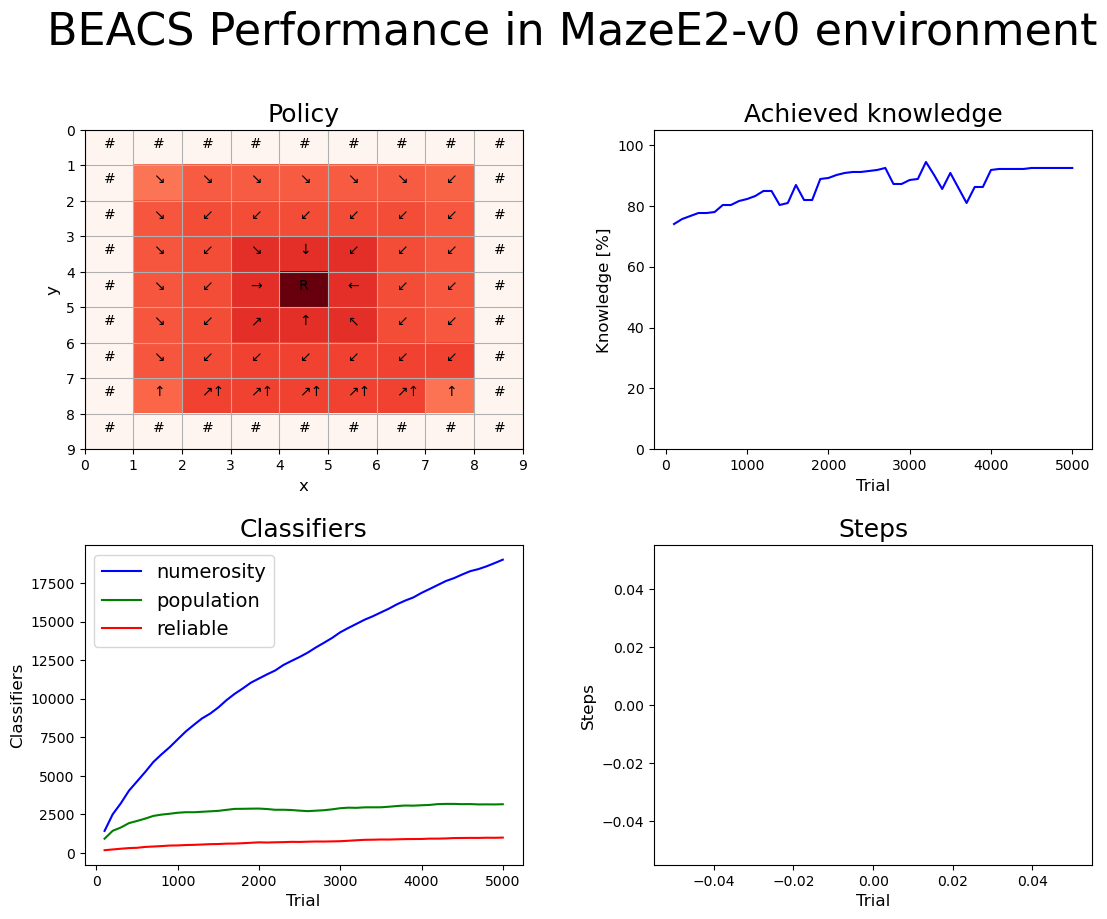

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  4  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 92.43421052631578, 'population': 3159, 'numerosity': 19007, 'reliable': 996}
Mean reliable population specifity is  0.7168674698795181
Accumulated Error on PEP Probabilities : 1.7982603376821573 %

There are  3  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 92.43421052631578, 'population': 667, 'numerosity': 9319, 'reliable': 591}
Mean reliable population specifity is  0.6791455160744501
Accumulated Error on PEP Probabilities : 1.89018193599365 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

#9###### 1 None (#0######:#486)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.03983
exp: 436   num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 174777 tbseq: 173263 talp: 174777 tav: 385.3  



#######9 7 None (#######0:#485)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.03287
exp: 433   num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 174443 tbseq: 174662 talp: 174443 tav: 296.2  



9####### 0 None (0#######:#473)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.04019
exp: 424   num: 13 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 175065 tbseq: 174041 talp: 175065 tav: 401.2  



#####9## 5 None (#####0##:#427)
q: 1.0    ra: 1e+03  rb: 999.9  ir: 1e+03  f: 1e+03  err: 0.1311
exp: 377   num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 175037 tbseq: 166831 talp: 175037 tav: 596.3  



######9# 6 None (######0#:#453)
q: 1.0    ra: 999.9  rb: 999.9  ir: 1e+03  f: 999.9  err: 0.1557
exp: 371   num: 




###1#1#1 1 [0] (###00000:#41)
q: 0.9745 ra: 402.9  rb: 436.0  ir: 0.0    f: 408.8  err: 348.4 
exp: 41    num: 15 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 163941 tbseq: 16004 talp: 163941 tav: 4.472e+03 



#9###### 3 [0] (90######:#27)
q: 0.996  ra: 478.4  rb: 341.2  ir: 0.0    f: 408.1  err: 470.4 
exp: 27    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 169584 tbseq: 4493  talp: 169584 tav: 6.549e+03 



#11####1 5 None (0000###0:#347)
q: 0.525  ra: 769.0  rb: 773.6  ir: 0.0    f: 406.1  err: 2.06  
exp: 2     num: 1 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 173201 tbseq: 174322 talp: 173274 tav: 362.8  



####0#9# 7 None (####9#0#:#41)
q: 0.9126 ra: 274.1  rb: 444.9  ir: 0.0    f: 406.1  err: 443.1 
exp: 32    num: 15 ee: False
Mark: empty Aliased_state:  PAI_state: 
tga: 172409 tbseq: 171999 talp: 172409 tav: 5.783e+03 



01110000 7 [3, 0] (########:#30, 1######1:#21)
q: 0.9702 ra: 415.7  rb: 423.9  ir: 0.0    f: 403



111100#1 5 [2] (0######0:#30)
q: 0.9484 ra: 284.8  rb: 287.9  ir: 0.0    f: 271.6  err: 339.8 
exp: 31    num: 13 ee: True
Mark: 11110001 Aliased_state:  PAI_state: 00000000
tga: 168308 tbseq: 2615  talp: 168308 tav: 5.494e+03 



00#00#9# 3 [0, 0] (######0#:#30)
q: 0.908  ra: 298.2  rb: 436.8  ir: 0.0    f: 270.7  err: 377.9 
exp: 30    num: 13 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 171775 tbseq: 57857 talp: 171775 tav: 3.948e+03 



###1##11 0 [1] (###00000:#24)
q: 0.9324 ra: 297.8  rb: 281.1  ir: 0.0    f: 269.9  err: 353.4 
exp: 24    num: 20 ee: False
Mark: empty Aliased_state:  PAI_state: 00000111
tga: 167384 tbseq: 9349  talp: 167384 tav: 6.645e+03 



###90### 0 [0, 3] (###0####:#32)
q: 0.9288 ra: 455.6  rb: 290.2  ir: 0.0    f: 269.6  err: 363.7 
exp: 32    num: 19 ee: False
Mark: empty Aliased_state:  PAI_state: 00000000
tga: 172565 tbseq: 18746 talp: 172565 tav: 4.915e+03 



##90###0 6 [6, 3] (##0#####:#33)
q: 0.9324 ra: 385.9  rb: 288.6  ir: 0.0  

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '1', '1', '1', '0', '0', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 24 s, sys: 217 ms, total: 24.2 s
Wall time: 25.6 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 20.5 s, sys: 56 ms, total: 20.6 s
Wall time: 20.7 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 20.1 s, sys: 30.5 ms, total: 20.2 s
Wall time: 20.2 s


### Performance

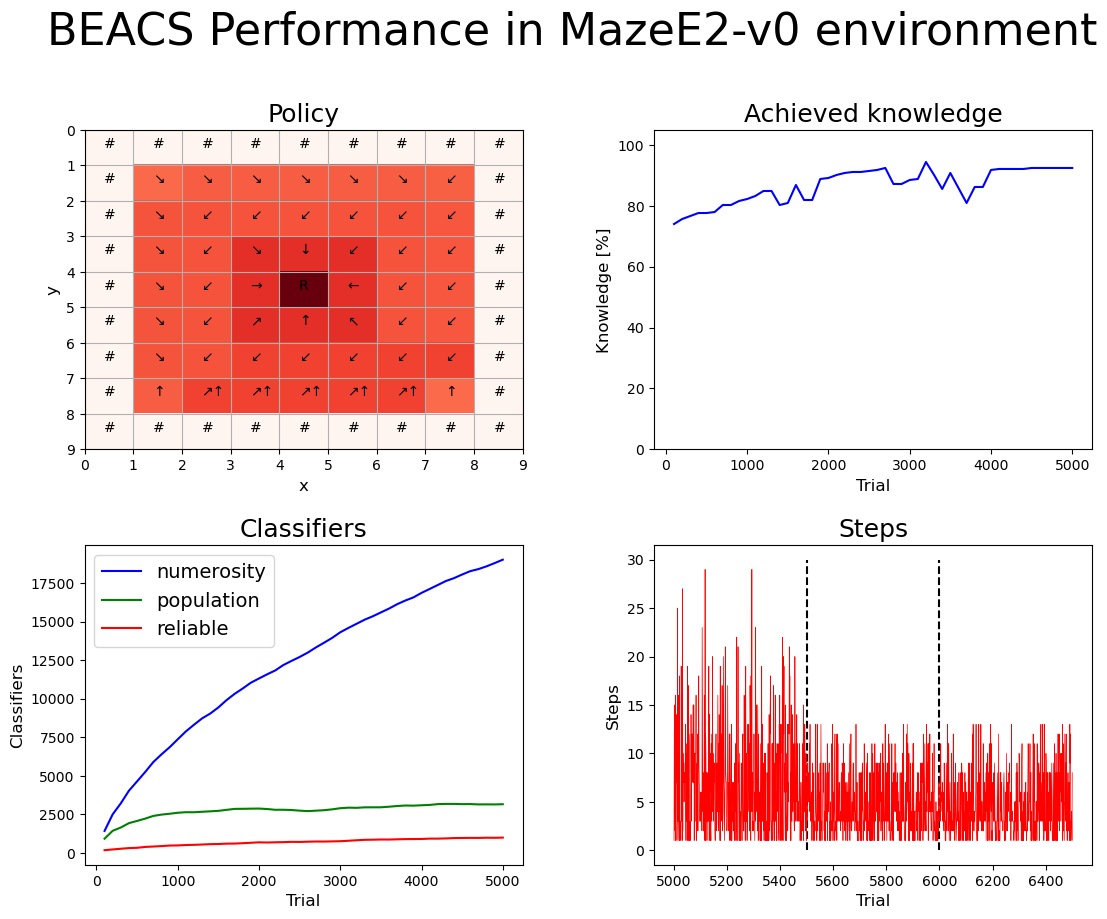

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  38.68  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  6.886  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  4.728  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.762  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 92.43421052631578, 'population': 667, 'numerosity': 9319, 'reliable': 591}
{'knowledge': 92.43421052631578, 'population': 667, 'numerosity': 9319, 'reliable': 591}
{'knowledge': 92.43421052631578, 'population': 667, 'numerosity': 9319, 'reliable': 591}
{'knowledge': 92.43421052631578, 'population': 667, 'numerosity': 9319, 'reliable': 591}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

458


000111#0 1 [0] (###000##:#153, #9#000##:#167, 9##000##:#142, ###000#9:#139, #11#00##:#131)
q: 1.0    ra: 912.3  rb: 895.4  ir: 0.0    f: 903.9  err: 69.13 
exp: 718   num: 19 ee: False
Mark: empty Aliased_state: 00011100 PAI_state: 00000000
tga: 175065 tbseq: 62697 talp: 175065 tav: 70.42  



00000000 0 [4, 5] (###111##:#29, #####111:#28, ####9###:#6, #####9##:#8, ###11111:#5, #######9:#3, ######9#:#5, ###9####:#7, ########:#5)
q: 0.999  ra: 788.8  rb: 781.6  ir: 0.0    f: 780.8  err: 75.91 
exp: 49    num: 20 ee: False
Mark: empty Aliased_state: 00000000 PAI_state: 11000001
tga: 169679 tbseq: 75676 talp: 169679 tav: 2.575e+03 



#0##1100 0 [6, 1] (9##000##:#30, ###000##:#27, ###000#9:#25, #9#000##:#19)
q: 0.9754 ra: 769.4  rb: 777.8  ir: 0.0    f: 750.5  err: 169.8 
exp: 54    num: 9 ee: False
Mark: empty Aliased_state: 00011100 PAI_state: 00000000
tga: 169576 tbseq: 59396 talp: 169576 tav: 2.738e+03 



00000000 5 [7, 1] (11#####1:#21, ########:#88, ######9#:#7, #######9:#4, 